In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


2024-02-17 16:41:53.909545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 16:41:53.909641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 16:41:54.026392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Directory Variables

will change values based on environment we are in

In [2]:
train_val_path = "/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/"
test_folder_path = "/kaggle/input/new-plant-diseases-dataset/test/test/"

In [3]:
train_folder_path = train_val_path + "train/"
val_folder_path = train_val_path + "valid/"

In [4]:
class_names = os.listdir(train_folder_path)

# Pre-processing

In [7]:
def train_data_generator(batch_size, shuffle=True):
    train_img_paths = []

    for i, label in enumerate(class_names):
        label_folder_path = train_folder_path + label + '/'
        for img_name in os.listdir(label_folder_path):
            img_path = label_folder_path + img_name
            train_img_paths.append((img_path, i))

    while True:
        if shuffle:
            np.random.shuffle(train_img_paths)

        for img_path_idx in range(0, len(train_img_paths), batch_size):
            batch_paths = train_img_paths[img_path_idx:img_path_idx + batch_size]
            batch = []
            batch_y = []
            for batch_img_path in batch_paths:
                img = plt.imread(batch_img_path[0]) # img shape is (256, 256, 3)
                # can add more pre-processing here
                batch.append(img)
                
                y = [0 for _ in range(38)]
                y[batch_img_path[1]] = 1
                batch_y.append(y)
            
            yield np.array(batch), np.array(batch_y)

In [8]:
def val_data_generator(batch_size, shuffle=True):
    val_img_paths = []

    for i, label in enumerate(class_names):
        label_folder_path = val_folder_path + label + '/'
        for img_name in os.listdir(label_folder_path):
            img_path = label_folder_path + img_name
            val_img_paths.append((img_path, i))

    while True:
        if shuffle:
            np.random.shuffle(val_img_paths)
        
        for img_path_idx in range(0, len(val_img_paths), batch_size):
            batch_paths = val_img_paths[img_path_idx:img_path_idx + batch_size]
            batch = []
            batch_y = []
            for batch_img_path in batch_paths:
                img = plt.imread(batch_img_path[0]) # img shape is (256, 256, 3)
                # can add more pre-processing here
                batch.append(img)
                
                y = [0 for _ in range(38)]
                y[batch_img_path[1]] = 1
                batch_y.append(y)
            
            yield np.array(batch), np.array(batch_y)

In [9]:
# # Training Image augmentation
# train_gen = ImageDataGenerator(
#     shear_range=0.2, zoom_range=0.2,
#     horizontal_flip=False, 
#     vertical_flip=False,
#     fill_mode='nearest', 
#     width_shift_range=0.2,
#     height_shift_range=0.2
# ) # returns shape (224, 224, 3)

# train = train_gen.flow_from_directory(
#     directory=train_folder_path,
#     batch_size=32,
#     target_size=(224,224),
#     color_mode='rgb', 
#     class_mode='categorical',
#     seed=42
# )


# val_gen = ImageDataGenerator()

# valid = val_gen.flow_from_directory(
#     directory=val_folder_path,
#     batch_size=32,
#     target_size=(224,224),
#     color_mode='rgb',
#     class_mode='categorical'
# )


# Model

In [10]:
keras.backend.set_image_data_format('channels_last')

base_model_tf = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3),
    classes=38,
)

base_model_tf.trainable = False

pt = Input(shape=(256, 256, 3))
x = tf.cast(pt, tf.float32)
x = preprocess_input(x) # to zero-center each color channel wrt Imagenet dataset

model_resnet = base_model_tf(x, training=False)
model_resnet = GlobalAveragePooling2D()(model_resnet)
model_resnet = Dense(512, activation='relu')(model_resnet)
model_resnet = Dense(128, activation='relu')(model_resnet)
model_resnet = Dense(64, activation='relu')(model_resnet)
model_resnet = Dense(38, activation='softmax')(model_resnet)


model_main = Model(inputs=pt, outputs=model_resnet)
model_main.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                              

In [11]:
es = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1, patience=3, mode='auto'
)
mc = ModelCheckpoint(
    filepath='/content', 
    monitor='val_accuracy', 
    verbose=1, save_best_only=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    verbose=1, patience=2, min_lr=0.001
)

In [12]:
model_main.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_main.fit(
    train_data_generator(32),
    validation_data=val_data_generator(32),
    validation_steps=550,
    epochs=10, steps_per_epoch=2197,
    callbacks=[mc, es, lr]
)

Epoch 1/10


I0000 00:00:1708188144.939166      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2197/2197 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9217
Epoch 1: val_accuracy improved from -inf to 0.93467, saving model to /content
2197/2197 [==============================] - 558s 251ms/step - loss: 0.2565 - accuracy: 0.9217 - val_loss: 0.2081 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 2/10
2197/2197 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9705
Epoch 2: val_accuracy improved from 0.93467 to 0.97331, saving model to /content
2197/2197 [==============================] - 217s 99ms/step - loss: 0.0890 - accuracy: 0.9705 - val_loss: 0.0762 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/10
2197/2197 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9791
Epoch 3: val_accuracy improved from 0.97331 to 0.97934, saving model to /content
2197/2197 [==============================] - 216s 98ms/step - loss: 0.0630 - accuracy: 0.9791 - val_loss: 0.0594 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 4/10
2197/2197 [=======

In [13]:
model_main.save("resent_plant_village_final.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training and Validation Data Viz

Text(0.5, 1.0, 'loss')

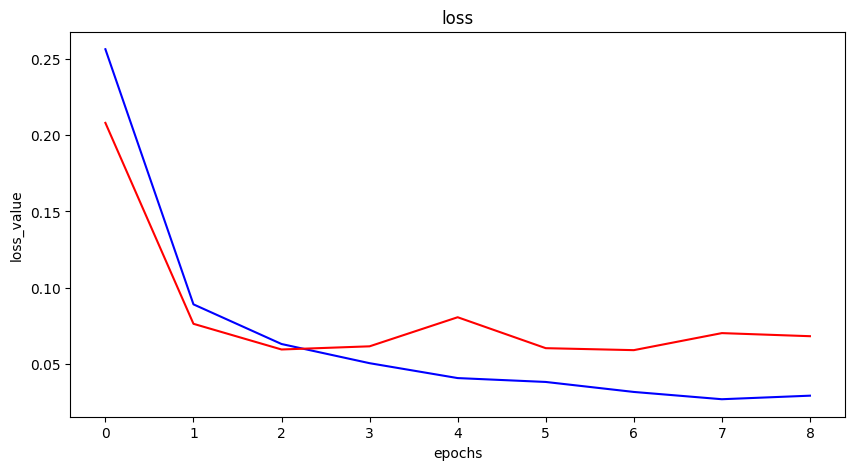

In [14]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'], color='b', label='Training loss')
plt.plot(model_main.history.history['val_loss'], color='r', label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")

Text(0.5, 1.0, 'accuracy graph')

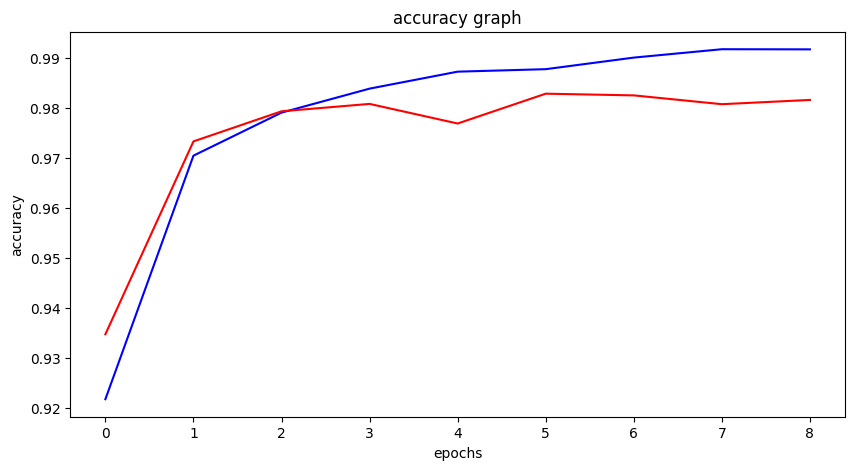

In [15]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")

# Testing

In [16]:
loaded_model = load_model("/kaggle/working/resent_plant_village_final.h5")

In [17]:
def manual_encode(img_path):
    if "AppleCedarRust" in img_path:
        return 20
    if "AppleScab" in img_path:
        return 13
    if "CornCommonRust" in img_path:
        return 31
    if "PotatoEarlyBlight" in img_path:
        return 29
    if "PotatoHealthy" in img_path:
        return 6
    if "TomatoEarly" in img_path:
        return 8
    if "TomatoHealthy" in img_path:
        return 1
    if "TomatoYellow" in img_path:
        return 14
    

In [18]:
def test_data_generator(batch_size, shuffle=True):
    test_paths = []
    for img_path in os.listdir(test_folder_path):
        test_paths.append(test_folder_path + img_path)
    
    if shuffle:
        test_paths = np.array(test_paths)
        np.random.shuffle(test_paths)
    
    for test_idx in range(0, len(test_paths), batch_size):
        batch = []
        batch_y = []
        for test_batch_idx in range(test_idx, test_idx + batch_size):
            img_path = test_paths[test_batch_idx]
            batch.append(cv2.imread(img_path))
            
            y = [0 for _ in range(38)]
            y[manual_encode(img_path)] = 1
            batch_y.append(y)
            
        
        batch = np.array(batch); batch_y = np.array(batch_y)
        yield batch, batch_y

In [19]:
predictions = loaded_model.evaluate(test_data_generator(1, False))

33/33 [==============================] - 2s 16ms/step - loss: 2.6536 - accuracy: 0.6667
